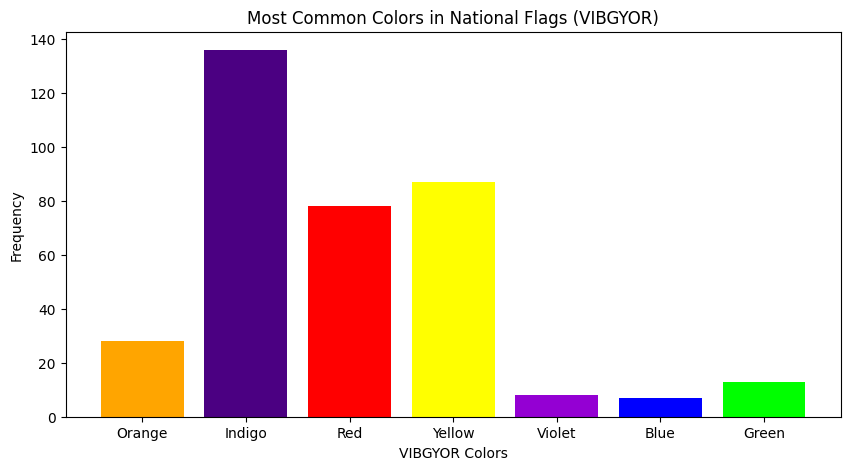

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cairosvg
from sklearn.cluster import KMeans
from collections import Counter
from scipy.spatial import distance

# Define VIBGYOR colors in RGB
VIBGYOR_COLORS = {
    "Violet":   (148, 0, 211),
    "Indigo":   (75, 0, 130),
    "Blue":     (0, 0, 255),
    "Green":    (0, 255, 0),
    "Yellow":   (255, 255, 0),
    "Orange":   (255, 165, 0),
    "Red":      (255, 0, 0)
}

# Directory containing SVG flags
FLAG_SVG_DIR = "/kaggle/input/country-flagssvgs/svg"
FLAG_PNG_DIR = "flags_png"

# Ensure the output directory exists
os.makedirs(FLAG_PNG_DIR, exist_ok=True)

def convert_svg_to_png(svg_path, png_path, width=200, height=150):
    """ Convert an SVG file to PNG format for analysis """
    cairosvg.svg2png(url=svg_path, write_to=png_path, output_width=width, output_height=height)

def get_dominant_colors(image_path, k=4):
    """ Extract dominant colors from a flag using K-Means clustering """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.reshape((-1, 3))  # Flatten the image

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(image)
    
    colors = kmeans.cluster_centers_.astype(int)
    return colors  # Return array of dominant colors

def closest_vibgyor_color(color):
    """ Find the closest VIBGYOR color to a given color """
    return min(VIBGYOR_COLORS, key=lambda c: distance.euclidean(color, VIBGYOR_COLORS[c]))

# Count occurrences of each VIBGYOR color
vibgyor_count = Counter()

# Process flags
for svg_file in os.listdir(FLAG_SVG_DIR):
    if svg_file.endswith(".svg"):
        flag_name = os.path.splitext(svg_file)[0]
        svg_path = os.path.join(FLAG_SVG_DIR, svg_file)
        png_path = os.path.join(FLAG_PNG_DIR, flag_name + ".png")

        convert_svg_to_png(svg_path, png_path)
        dominant_colors = get_dominant_colors(png_path, k=3)

        for color in dominant_colors:
            vibgyor_color = closest_vibgyor_color(color)
            vibgyor_count[vibgyor_color] += 1  # Update count

# Plot results
plt.figure(figsize=(10, 5))
plt.bar(vibgyor_count.keys(), vibgyor_count.values(), color=[np.array(VIBGYOR_COLORS[c]) / 255 for c in vibgyor_count.keys()])
plt.xlabel("VIBGYOR Colors")
plt.ylabel("Frequency")
plt.title("Most Common Colors in National Flags (VIBGYOR)")
plt.show()


In [6]:
pip install cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Text Analysis


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


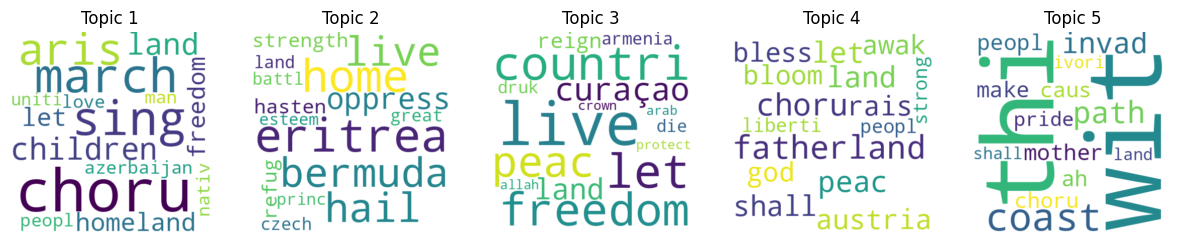

In [18]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

# Ensure you have the required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Function to load anthem texts from a folder
def load_anthem_texts(folder_path):
    texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):  # Assuming anthems are stored as text files
            with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as file:
                texts.append(file.read())
    return texts

# Function to preprocess text (tokenization, stopword removal, stemming)
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters and punctuation
    words = word_tokenize(text)  # Tokenization
    words = [w for w in words if w not in stopwords.words('english')]  # Remove stopwords
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]  # Apply stemming
    return " ".join(words)  # Return cleaned text as a single string

# Load and preprocess all anthems
folder_path = "/kaggle/input/country-anthems-text/anthem_text"  # Change this to the actual folder path
anthem_texts = load_anthem_texts(folder_path)
processed_anthems = [preprocess_text(text) for text in anthem_texts]

# Convert text data to TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # Limit features to 1000 for efficiency
document_term_matrix = vectorizer.fit_transform(processed_anthems)

# Train LDA Model
num_topics = 5  # Set the number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(document_term_matrix)

# Function to plot word clouds for each topic
def plot_word_clouds(lda_model, feature_names, num_topics):
    fig, axes = plt.subplots(1, num_topics, figsize=(15, 6), sharex=True, sharey=True)
    for topic_idx, ax in enumerate(axes):
        topic_words = lda_model.components_[topic_idx]
        top_words = {feature_names[i]: topic_words[i] for i in topic_words.argsort()[-15:]}
        wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(top_words)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(f"Topic {topic_idx + 1}")
    plt.show()

# Visualize Topics
plot_word_clouds(lda_model, vectorizer.get_feature_names_out(), num_topics)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Generating Stacked Bar Chart...


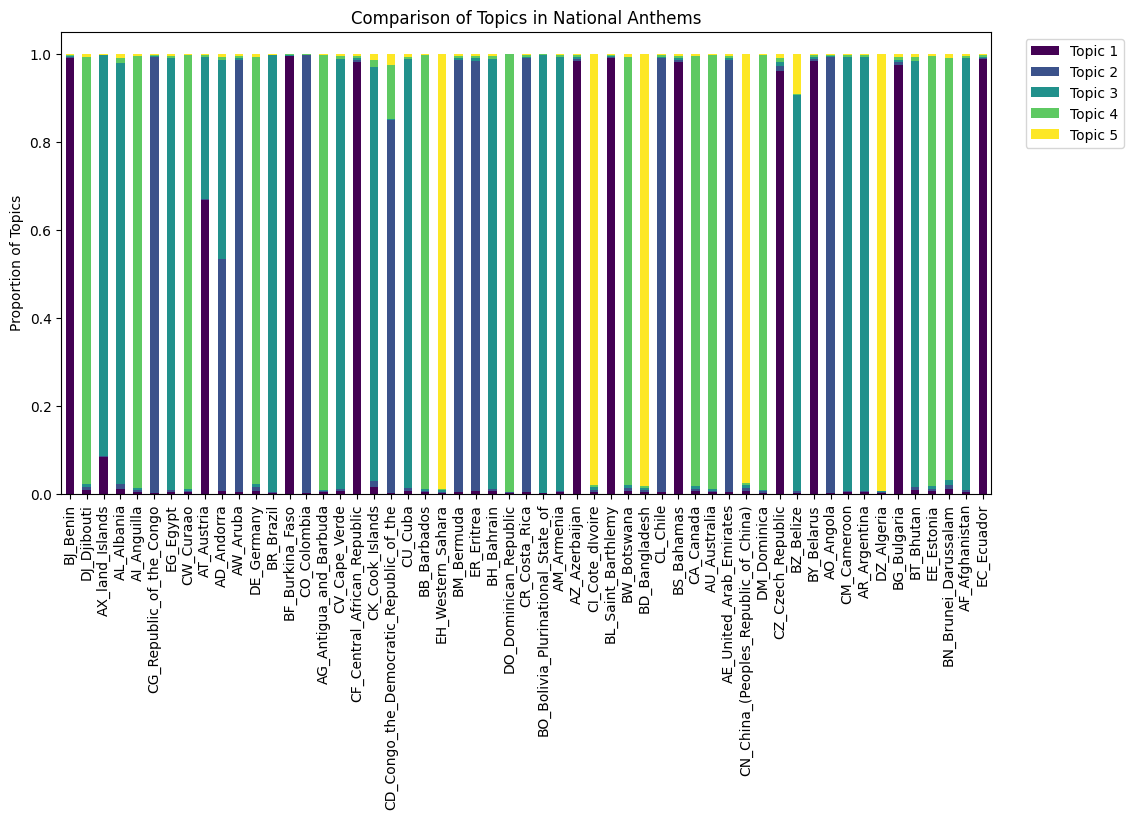

In [20]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

# Ensure NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')

# Load anthem texts
def load_anthem_texts(folder_path):
    texts, anthem_names = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as file:
                texts.append(file.read())
                anthem_names.append(filename.replace(".txt", ""))  # Store anthem name
    return texts, anthem_names

# Preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    words = word_tokenize(text)
    words = [w for w in words if w not in stopwords.words('english')]
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    return " ".join(words)

# Load data
folder_path = "/kaggle/input/country-anthems-text/anthem_text"
anthem_texts, anthem_names = load_anthem_texts(folder_path)
processed_anthems = [preprocess_text(text) for text in anthem_texts]

# Convert to document-term matrix
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
document_term_matrix = vectorizer.fit_transform(processed_anthems)

# Train LDA Model
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
topic_distribution = lda_model.fit_transform(document_term_matrix)

# Create DataFrame for topic distributions
df_topics = pd.DataFrame(topic_distribution, index=anthem_names, columns=[f"Topic {i+1}" for i in range(num_topics)])

### 1️⃣ Stacked Bar Chart: Topic Distribution Per Anthem
def plot_stacked_bar(df):
    df.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
    plt.ylabel("Proportion of Topics")
    plt.title("Comparison of Topics in National Anthems")
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.xticks(rotation=90)
    plt.show()

print("Generating Stacked Bar Chart...")
plot_stacked_bar(df_topics)




In [21]:
# Get top words for each topic
def print_top_words(lda_model, feature_names, n_top_words=10):
    topic_labels = {}  # Store identified topic names
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

        # Identify topics manually based on words
        if "freedom" in top_words or "independence" in top_words:
            topic_labels[f"Topic {topic_idx+1}"] = "Freedom & Independence"
        elif "god" in top_words or "faith" in top_words:
            topic_labels[f"Topic {topic_idx+1}"] = "Religion & Devotion"
        elif "battle" in top_words or "victory" in top_words:
            topic_labels[f"Topic {topic_idx+1}"] = "War & Struggle"
        elif "land" in top_words or "beauty" in top_words:
            topic_labels[f"Topic {topic_idx+1}"] = "Nature & Homeland"
        else:
            topic_labels[f"Topic {topic_idx+1}"] = "Miscellaneous"

    return topic_labels

# Print and store topic labels
topic_labels = print_top_words(lda_model, vectorizer.get_feature_names_out())


Topic 1: choru, land, peopl, azerbaijan, glori, austria, home, victori, thousand, freedom
Topic 2: choru, peopl, countri, live, work, great, let, glori, oppress, shall
Topic 3: freedom, land, choru, homeland, free, live, let, die, peac, love
Topic 4: let, land, fatherland, free, thee, liberti, god, heart, fair, love
Topic 5: wit, live, path, thi, aris, peopl, algeria, determin, invad, shall


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


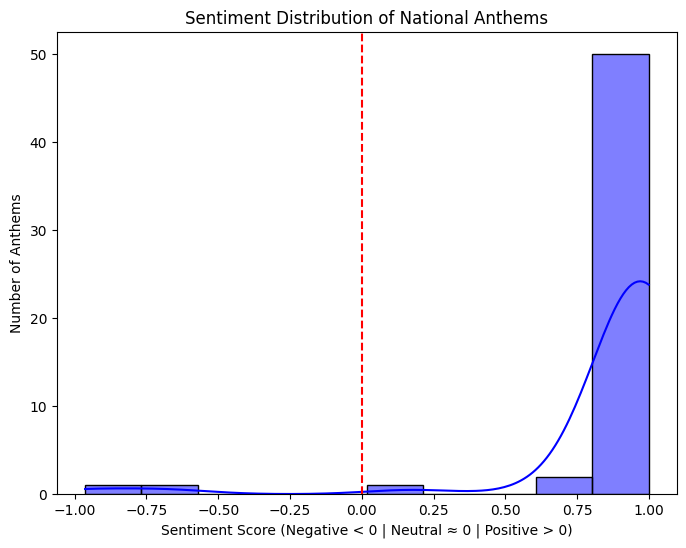

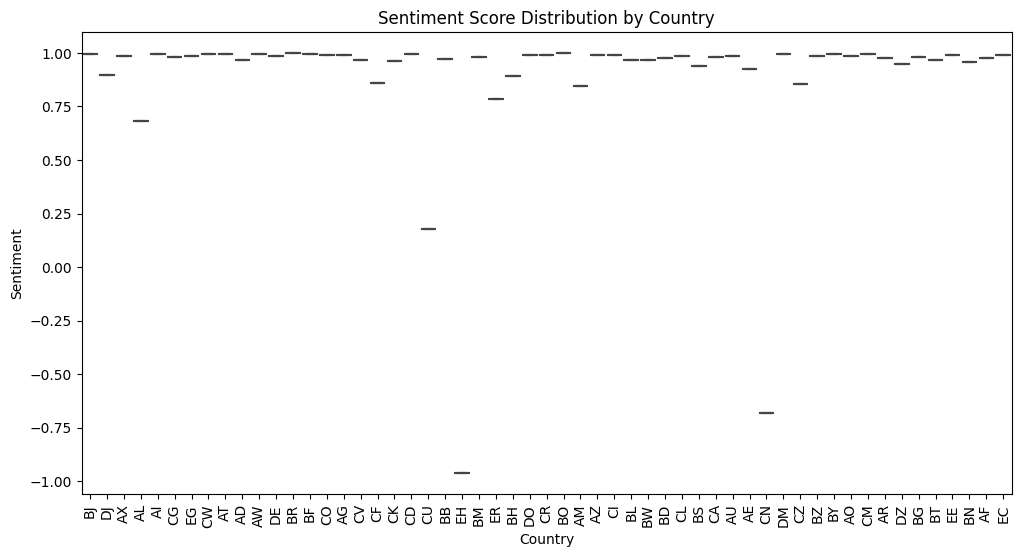

In [25]:
import os
import re
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# Download required NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("vader_lexicon")

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to load national anthem texts from a folder
def load_anthem_texts(folder_path):
    anthem_texts = []
    anthem_filenames = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):  # Assuming each anthem is a text file
            with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as file:
                text = file.read()
                anthem_texts.append(text)
                anthem_filenames.append(filename)
    
    return anthem_texts, anthem_filenames

# Function to preprocess text (remove special characters, tokenize, remove stopwords)
def preprocess_text(text):
    text = re.sub(r"\W", " ", text.lower())  # Remove special characters & lowercase
    words = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    words = [w for w in words if w not in stop_words]  # Remove stopwords
    return " ".join(words)

# Function to analyze sentiment of an anthem
def analyze_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment["compound"]  # Compound score summarizes overall sentiment

# Function to plot sentiment distribution
def plot_sentiment_distribution(sentiment_scores):
    plt.figure(figsize=(8, 6))
    sns.histplot(sentiment_scores, bins=10, kde=True, color="blue")
    plt.axvline(0, color='red', linestyle='dashed')  # Neutral boundary
    plt.title("Sentiment Distribution of National Anthems")
    plt.xlabel("Sentiment Score (Negative < 0 | Neutral ≈ 0 | Positive > 0)")
    plt.ylabel("Number of Anthems")
    plt.show()

# Function to visualize sentiment scores by country
def plot_country_sentiment(df_analysis):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Country", y="Sentiment", data=df_analysis)
    plt.xticks(rotation=90)
    plt.title("Sentiment Score Distribution by Country")
    plt.show()

# MAIN EXECUTION
folder_path = "/kaggle/input/country-anthems-text/anthem_text"  
# Load and preprocess anthems
anthem_texts, anthem_filenames = load_anthem_texts(folder_path)
processed_anthems = [preprocess_text(text) for text in anthem_texts]

# Get sentiment scores
sentiment_scores = [analyze_sentiment(text) for text in anthem_texts]

# Create DataFrame for analysis
df_analysis = pd.DataFrame({
    "Anthem": anthem_filenames,
    "Sentiment": sentiment_scores
})

# Extract country names from filenames
df_analysis["Country"] = [name.split("_")[0] for name in anthem_filenames]

# Visualization
plot_sentiment_distribution(sentiment_scores)
plot_country_sentiment(df_analysis)


In [26]:
# Filter countries with sentiment score < 0.5
low_sentiment_countries = df_analysis[df_analysis["Sentiment"] < 0.5]

# Display results
print("Countries with sentiment score < 0.5:")
print(low_sentiment_countries[["Country", "Sentiment"]])


Countries with sentiment score < 0.5:
   Country  Sentiment
20      CU     0.1754
22      EH    -0.9633
40      CN    -0.6826


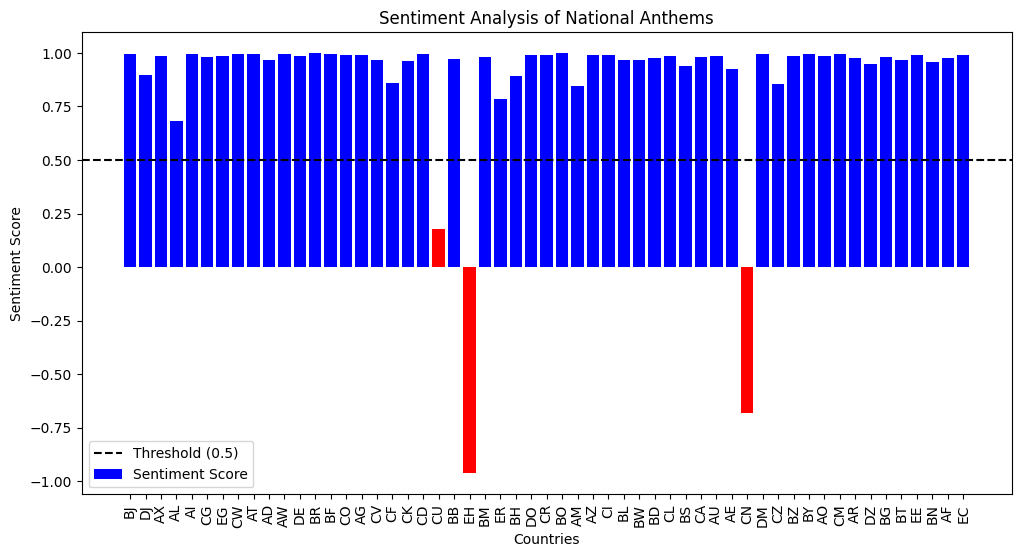

In [27]:
import matplotlib.pyplot as plt

# Define colors: Red for sentiment < 0.5, Blue otherwise
df_analysis["Color"] = df_analysis["Sentiment"].apply(lambda x: "red" if x < 0.5 else "blue")

# Plot the sentiment scores
plt.figure(figsize=(12, 6))
bars = plt.bar(df_analysis["Country"], df_analysis["Sentiment"], color=df_analysis["Color"])

# Add labels and title
plt.xlabel("Countries")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis of National Anthems")
plt.xticks(rotation=90)
plt.axhline(y=0.5, color="black", linestyle="--", label="Threshold (0.5)")
plt.legend(["Threshold (0.5)", "Sentiment Score"])

# Show the plot
plt.show()


# *Audio analysis***

In [ ]:
import librosa
import numpy as np
import os
import joblib  # To load the pre-trained model

# Load the Pre-Trained Model (Ensure the file exists)
model_path = "pretrained_anthem_emotion_model.pkl"  # Replace with your actual model file
scaler_path = "scaler.pkl"  # If a scaler was used in training

# Load Model & Scaler
model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

# 🎵 Function to Extract Audio Features
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    features = {
        'mfcc_mean': np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1),
        'chroma_stft': np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
        'spectral_contrast': np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)),
        'tempo': librosa.beat.tempo(y=y, sr=sr)[0]
    }
    return np.hstack([features['mfcc_mean'], features['chroma_stft'], features['spectral_contrast'], features['tempo']])

# 🎵 Analyze Emotions for All Anthem Files
anthem_folder = "path_to_anthems"  # Replace with your actual folder path
results = []

for filename in os.listdir(anthem_folder):
    if filename.endswith(".mp3") or filename.endswith(".wav"):
        file_path = os.path.join(anthem_folder, filename)
        try:
            features = extract_audio_features(file_path)
            features_scaled = scaler.transform([features])
            predicted_emotion = model.predict(features_scaled)[0]
            results.append((filename, predicted_emotion))
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# 🎵 Print Emotion Results
print("\n🎶 Anthem Emotion Detection Results 🎶")
for anthem, emotion in results:
    print(f"{anthem}: {emotion}")
